# Construct surface elevation time series along the centerline

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import numpy as np
import datetime
from tqdm.auto import tqdm
import xesmf as xe
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, LineString
import seaborn as sns

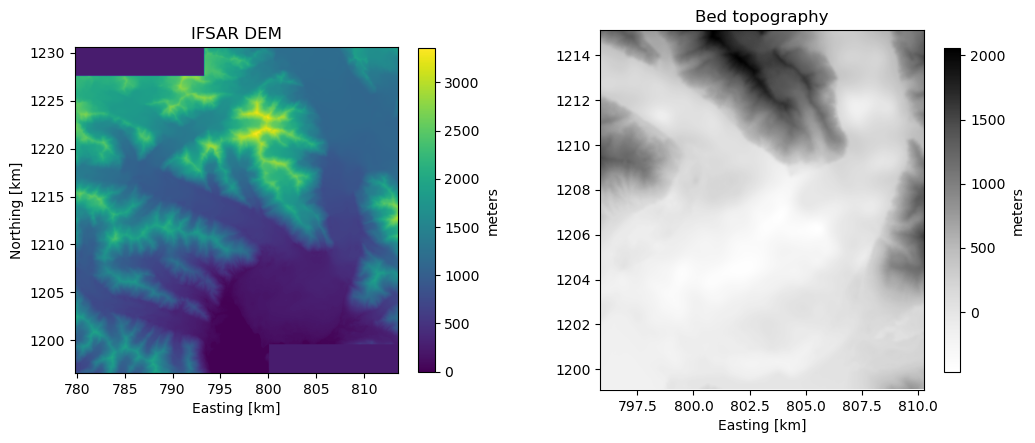

In [2]:
# -----Define paths to data
data_path = '/Users/raineyaberle/Research/PhD/Hubbard/'
figures_out_path = os.path.join(data_path, 'figures')
h_out_path = os.path.join(data_path, 'surface_elevation')

# -----Load bed data
bed_fn = os.path.join(data_path, 'bed_topo', 'hubbard_bedrock_icebridge.tif')
bed = rxr.open_rasterio(bed_fn)

# -----Load coregistered DEMs and rasterized ICESat-2 file names
h_fns = sorted(glob.glob(os.path.join(data_path, 'surface_elevation', 'surface_elevation_filtered_old', '*.tif')))

# -----Load IFSAR DEM
ifsar_fn = 'ifsar_hubbardDEM.tif'
ifsar = xr.open_dataset(os.path.join(data_path, 'surface_elevation', ifsar_fn))
# adjust dimensions
h = ifsar.band_data.data[0]
ifsar = ifsar.drop_dims('band')
ifsar['h'] = (('y', 'x'), h)
# Downsample to 20 m resolution
ifsar = ifsar.coarsen(x=4, y=4, boundary='pad').mean()

# -----Plot IFSAR DEM and bed topo
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ifsar_im = ax[0].imshow(ifsar['h'], cmap='viridis',
           extent=(np.min(ifsar.x.data)/1e3, np.max(ifsar.x.data)/1e3, 
                   np.min(ifsar.y.data)/1e3, np.max(ifsar.y.data)/1e3))
ax[0].set_xlabel('Easting [km]')
ax[0].set_ylabel('Northing [km]')
ax[0].set_title('IFSAR DEM')
fig.colorbar(ifsar_im, ax=ax[0], shrink=0.7, label='meters')
bed_im = ax[1].imshow(bed.data[0], cmap='Greys', 
                      extent=(np.min(bed.x.data)/1e3, np.max(bed.x.data)/1e3,
                              np.min(bed.y.data)/1e3, np.max(bed.y.data)/1e3))
ax[1].set_xlabel('Easting [km]')
ax[1].set_title('Bed topography')
fig.colorbar(bed_im, ax=ax[1], shrink=0.7, label='meters')
fig.subplots_adjust(wspace=0.3)
plt.show()

## Interpolate the surface and bed along the centerline

In [93]:
def create_distance_vector(line):
    x, y = line.coords.xy[0], line.coords.xy[1]
    line_dist = np.zeros(len(line.coords.xy[0]))
    for i in range(1, len(line.coords.xy[0])):
        line_dist[i] = np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2) + line_dist[i-1]
    return line_dist

def increase_linestring_resolution(line, distance=50):
    # create initial distance vector
    line_dist = create_distance_vector(line)
    
    # create new line distance vector
    new_line_dist = np.arange(0, np.nanmax(line_dist), step=distance)

    # interpolate coordinates on new distance vector
    new_x = np.interp(new_line_dist, line_dist, x)
    new_y = np.interp(new_line_dist, line_dist, y)

    # save as linestring
    new_coords = list(zip(new_x, new_y))
    new_line = LineString(new_coords)
    
    return new_line, new_line_dist

50 m centerline loaded from file.


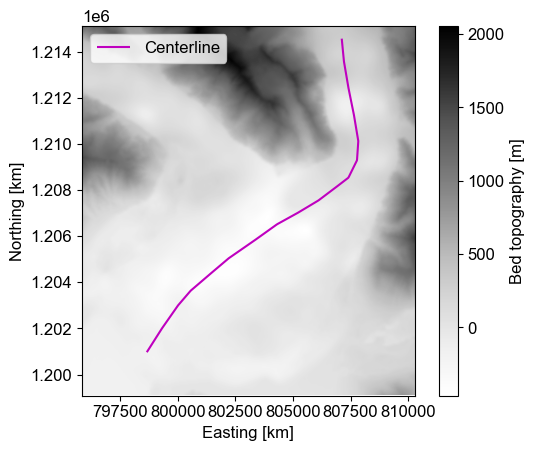

In [95]:
# -----Load centerline
# Check if resampled centerline already exists in file
cl_resamp_fn = os.path.join(data_path, 'velocity', 'center_50m.gpkg')
if os.path.exists(cl_resamp_fn):
    cl_resamp = gpd.read_file(cl_resamp_fn)
    cl_dist = create_distance_vector(cl_resamp.geometry[0])
    print('50 m centerline loaded from file.')
else:
    # load centerline
    cl_path = os.path.join(data_path, 'velocity', 'center.gpkg')
    cl = gpd.read_file(cl_path)
    # Reproject to Alaska Albers
    cl = cl.to_crs('EPSG:3338')
    # Increase spatial resolution
    new_geom, cl_dist = increase_linestring_resolution(cl.geometry[0])
    cl_resamp = cl.copy()
    cl_resamp['geometry'] = [new_geom]
    # Save to file
    cl_resamp.to_file(cl_resamp_fn)
    print('50 m centerline saved to file:', cl_resamp_fn)

# Sample bed data along centerline
cl_bed = [bed.sel(x=x, y=y, method='nearest').data[0] for x, y in zip(cl_x, cl_y)]

# Plot
fig, ax = plt.subplots()
bed_im = ax.imshow(bed.data[0], cmap='Greys', 
                      extent=(np.min(bed.x.data), np.max(bed.x.data),
                              np.min(bed.y.data), np.max(bed.y.data)))
ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')
cl_resamp.plot(ax=ax, color='m', label='Centerline')
ax.legend(loc='upper left')
fig.colorbar(bed_im, ax=ax, label='Bed topography [m]')
plt.show()

In [91]:
# -----Sample surface elevations from DEMs
# Check if sampled elevations already exist in file
h_cl_fn = os.path.join(data_path, 'surface_elevation', 'centerline_surface_elevation_timeseries.csv')
if os.path.exists(h_cl_fn):
    h_cl_df = pd.read_csv(h_cl_fn)
    dates = pd.to_datetime(h_cl_df['Date'])
    datasets = h_cl_df['Dataset']
    h_cl = h_cl_df.iloc[:,2:].values
    print('Centerline surface profiles loaded from file.')

else:
    
    # Initialize centerline surface heights
    h_cl = np.zeros((len(h_fns), len(cl.geometry[0].coords.xy[0])))
    dates = []
    datasets = []

    # Grab centerline x and y coordinates for convenience
    cl_x, cl_y = cl_resamp.geometry[0].coords.xy
    
    # Iterate over file names
    for i, fn in enumerate(h_fns):
        h_xda = rxr.open_rasterio(fn)
        dates.append(os.path.basename(fn)[0:10])
        datasets.append(os.path.basename(fn).split('_')[1])
        h_cl[i,:] = [h_xda.sel(x=x, y=y, method='nearest').data[0] for x,y in zip(cl_x, cl_y)]
    
    # Convert dates to datetimes
    dts = pd.DatetimeIndex([np.datetime64(date) for date in dates])
    
    # Remove wacky elevation values
    h_cl[np.abs(h_cl) > 1e4] = np.nan

    # Reformat as DataFrame and save to file
    h_cl_df = pd.DataFrame({'Date': dates,
                            'Dataset': datasets})
    for i in range(np.shape(h_cl)[1]):
        df = pd.DataFrame({str(cl_dist[i]): h_cl[:,i]})
        h_cl_df = pd.concat([h_cl_df, df], axis=1)
    
    h_cl_df.to_csv(h_cl_fn, index=False)
    print('Centerline surface elevations saved to file:', h_cl_fn)

h_cl

Centerline surface profiles loaded from file.


array([[         nan,          nan,          nan, ..., 130.11322403,
        125.01114655, 126.86282539],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ..., 113.02682304,
        122.2954483 , 126.89920616],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

## Smooth the elevation profiles

In [102]:
# -----Check if smoothed surface profiles already exist in directory
h_cl_smooth_fn = os.path.join(data_path, 'surface_elevation', 'centerline_surface_elevation_timeseries_smooth.csv')
if os.path.exists(h_cl_smooth_fn):
    h_cl_smooth_df = pd.read_csv(h_cl_smooth_fn)
    h_cl_smooth = h_cl_smooth_df.iloc[:,2:].values
    print('Smoothed surface profiles loaded from file.')

else:

    # Smooth each elevation profile
    def moving_average_smoothing(arr, window_size=5):
        smoothed_arr = np.zeros_like(arr)
        for i in range(arr.shape[0]):
            smoothed_arr[i, :] = np.convolve(arr[i, :], np.ones(window_size) / window_size, mode='same')
        return smoothed_arr
    h_cl_smooth = moving_average_smoothing(h_cl)
    h_cl_smooth[h_cl_smooth==0] = np.nan
    
    # Reformat as DataFrame and save to file
    h_cl_smooth_df = pd.DataFrame({'Date': dates,
                                   'Dataset': datasets})
    for i in range(np.shape(h_cl_smooth)[1]):
        df = pd.DataFrame({str(cl_dist[i]): h_cl_smooth[:,i]})
        h_cl_smooth_df = pd.concat([h_cl_smooth_df, df], axis=1)
    
    h_cl_smooth_df.to_csv(h_cl_smooth_fn, index=False)
    print('Smoothed centerline surface elevations saved to file:', h_cl_smooth_fn)

h_cl_smooth

Smoothed surface profiles loaded from file.


array([[         nan,          nan,          nan, ..., 123.61377907,
         98.80228615,  76.39743919],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ..., 124.3526783 ,
         97.50815239,  72.4442955 ],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

## Plot

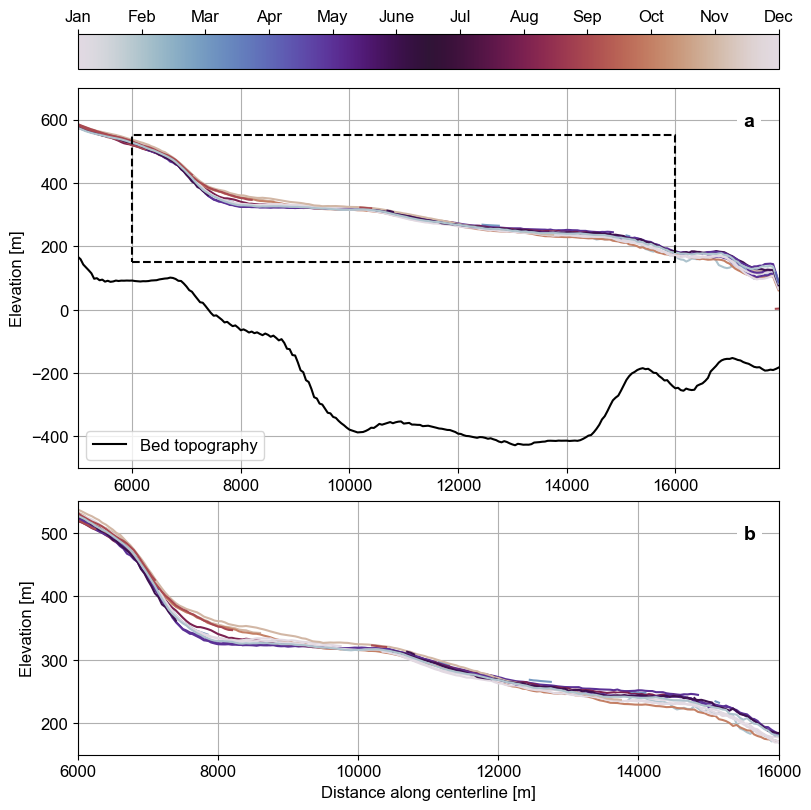

Figure saved to file: /Users/raineyaberle/Research/PhD/Hubbard/figures/centerline_surface_elevations_smooth.png


In [7]:
# Determine whether to plot smoothed or raw surface elevations
smoothed = True
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(2, 1, figsize=(8,8), layout='constrained', 
                       gridspec_kw={'height_ratios':[1.5, 1]})
lw=1.5

# Define colormap for surface profiles
cmap = plt.cm.twilight

# plot bed topo
ax[0].plot(cl_dist, cl_bed, '-k', label='Bed topography')
ax[1].plot(cl_dist, cl_bed, '-k', label='Bed topography')

for i in range(len(h_fns)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    if smoothed:
        ax[0].plot(cl_dist, h_cl_smooth[i,:], '-', linewidth=lw, color=color)
        ax[1].plot(cl_dist, h_cl_smooth[i,:], '-', linewidth=lw, color=color)
    else:
        ax[0].plot(cl_dist, h_cl[i,:], '-', linewidth=lw, color=color)
        ax[1].plot(cl_dist, h_cl[i,:], '-', linewidth=lw, color=color)

# Plot zoom in box on first panel
xmin, xmax = 6e3, 16e3
ymin, ymax = 150, 550
ax[0].plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], '--k')

# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, ax=ax[0], location='top')
cbar.ax.set_xticks(np.linspace(0,1,num=12))
cbar.ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adjust axes
ax[0].legend(loc='lower left')
ax[0].grid()
ax[0].set_ylabel('Elevation [m]')
ax[0].set_xlim(5e3, cl_dist[-1])
ax[0].set_ylim(-500, 700)
ax[0]
ax[1].grid()
ax[1].set_xlabel('Distance along centerline [m]')
ax[1].set_ylabel('Elevation [m]')
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)

# Add labels to panels
ax[0].text((ax[0].get_xlim()[1] - ax[0].get_xlim()[0]) * 0.95 + ax[0].get_xlim()[0],
           (ax[0].get_ylim()[1] - ax[0].get_ylim()[0]) * 0.9 + ax[0].get_ylim()[0],
           'a', fontweight='bold', fontsize=14, bbox=dict(facecolor='w', edgecolor='None', pad=5))
ax[1].text((ax[1].get_xlim()[1] - ax[1].get_xlim()[0]) * 0.95 + ax[1].get_xlim()[0],
           (ax[1].get_ylim()[1] - ax[1].get_ylim()[0]) * 0.85 + ax[1].get_ylim()[0],
           'b', fontweight='bold', fontsize=14, bbox=dict(facecolor='w', edgecolor='None', pad=5))
# Barcode plot of dates with elevation observations
# dts = pd.DatetimeIndex(dates)
# for dt in dts:
#     ax[2].plot([dt, dt], [0,1], '-k', linewidth=1)
# ax[2].set_yticks([])
# ax[2].set_xlim(np.datetime64('2009-01-01'), np.datetime64('2023-01-01'))
# ax[2].set_ylim(0,1)
# ax[2].set_title('Dates with surface observations')

plt.show()

# Save figure
if smoothed:
    fig_fn = os.path.join(figures_out_path, 'centerline_surface_elevations_smooth.png')
else:
    fig_fn = os.path.join(figures_out_path, 'centerline_surface_elevations.png')
fig.savefig(fig_fn, dpi=300)
print('Figure saved to file:', fig_fn)

## Assess how many observations each dataset is contributing to the elevation profiles

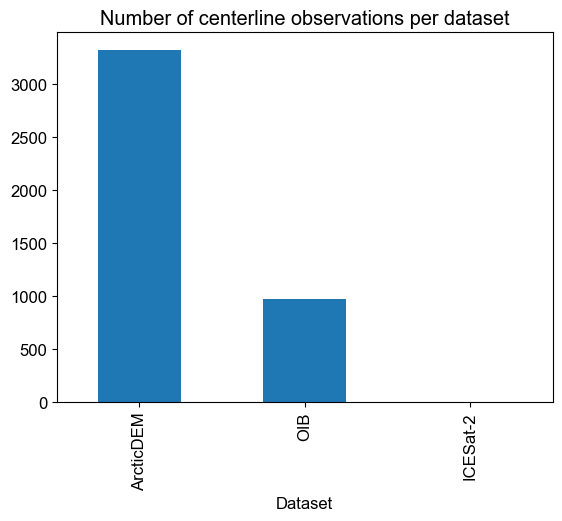

In [164]:
datasets = h_cl_df['Dataset'].drop_duplicates().values
obs_df = pd.DataFrame()
for dataset in datasets:
    h_cl_dataset = h_cl_df.loc[h_cl_df['Dataset']==dataset]
    
    obs = h_cl_dataset.drop(['Date', 'Dataset'], axis=1).values
    nobs=len(obs[~np.isnan(obs)])
    df = pd.DataFrame({'Dataset': [dataset], 'Obs.': [nobs]})
    obs_df = pd.concat([obs_df, df])
obs_df.reset_index(drop=True)
obs_df.plot.bar(x='Dataset', y='Obs.', legend=False)
plt.title('Number of centerline observations per dataset')
plt.show()

## Plot monthly trends up- and down-glacier

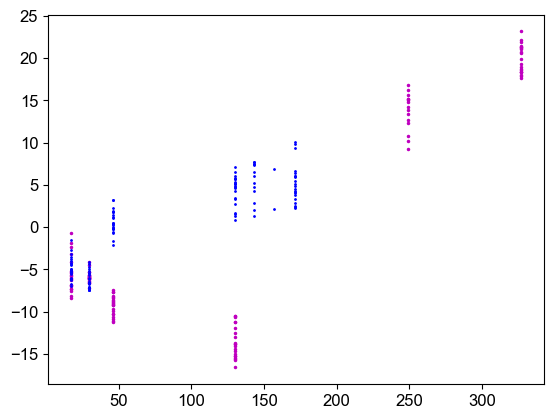

In [293]:
# Add Year and Month columns to centerline elevations df
h_cl_smooth_df['Year'] = pd.DatetimeIndex(h_cl_smooth_df['Date']).year
h_cl_smooth_df['Month'] = pd.DatetimeIndex(h_cl_smooth_df['Date']).month
h_cl_smooth_df['DOY'] = pd.DatetimeIndex(h_cl_smooth_df['Date']).dayofyear
cl_cols = [x for x in list(h_cl_smooth_df.columns) if '.0' in x]
cl_cols_float = np.array(cl_cols).astype(float)

# Remove the mean
h_cl_smooth_demean_df = h_cl_smooth_df.copy()
h_cl_smooth_demean_df[cl_cols] -= h_cl_smooth_demean_df[cl_cols].mean()
for col in cl_cols:
    h_cl_smooth_demean_df.loc[np.abs(h_cl_smooth_demean_df[col]) > 50, col] = np.nan

# Remove dates before 2016
h_cl_smooth_demean_df = h_cl_smooth_demean_df.loc[h_cl_smooth_demean_df['Year'] >= 2016].reset_index(drop=True)

# Define indices or up- and down-glacier regions
Iup = np.ravel(np.argwhere((cl_cols_float >= 7.5e3) & (cl_cols_float <= 8.5e3)))
Idown = np.ravel(np.argwhere((cl_cols_float >= 14e3) & (cl_cols_float <= 15e3)))
cols_up = [cl_cols[i] for i in Iup]
cols_down = [cl_cols[i] for i in Idown]

# Plot
fig, ax = plt.subplots(1, 1)
ax.plot(h_cl_smooth_demean_df['DOY'], h_cl_smooth_demean_df[cols_up], '.m', markersize=3, label='Up')
ax.plot(h_cl_smooth_demean_df['DOY'], h_cl_smooth_demean_df[cols_down], 'ob', markersize=1, label='Down')
# ax.legend(loc='best')
plt.show()

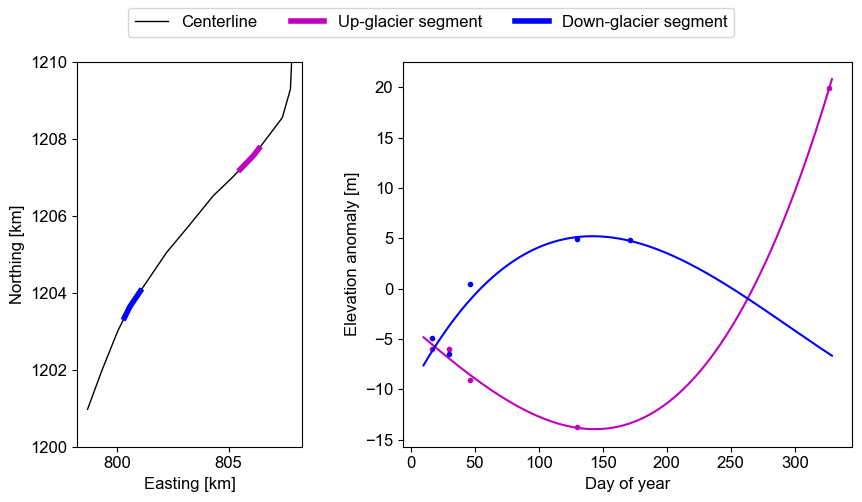

Figure saved to file: /Users/raineyaberle/Research/PhD/Hubbard/figures/centerline_segments_surface_elevations_spline.png


In [321]:
from scipy.interpolate import splrep, BSpline

fig, ax = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios':[1,2]})
ax[0].plot(np.divide(cl_resamp.geometry[0].coords.xy[0], 1e3),
           np.divide(cl_resamp.geometry[0].coords.xy[1], 1e3), 
           '-k', linewidth=1, label='Centerline')
ax[0].plot(np.divide([cl_resamp.geometry[0].coords.xy[0][i] for i in Iup], 1e3),
           np.divide([cl_resamp.geometry[0].coords.xy[1][i] for i in Iup], 1e3), 
           '-m', linewidth=4, label='Up-glacier segment')
ax[0].plot(np.divide([cl_resamp.geometry[0].coords.xy[0][i] for i in Idown], 1e3),
           np.divide([cl_resamp.geometry[0].coords.xy[1][i] for i in Idown], 1e3), 
           '-b', linewidth=4, label='Down-glacier segment')
ax[0].set_ylim(1200, 1210)
ax[0].set_xlabel('Easting [km]')
ax[0].set_ylabel('Northing [km]')

for i, cols in enumerate([cols_up, cols_down]):

    df = h_cl_smooth_demean_df[['DOY'] + cols].sort_values(by='DOY').dropna().reset_index(drop=True)
    df['Mean'] = df[cols].mean(axis=1)
    df['Median'] = df[cols].median(axis=1)
    
    X = df['DOY']
    y = df['Median'].values
    tck = splrep(X, y, s=50)
    X_spline = np.arange(10,330)
    y_spline = BSpline(*tck)(X_spline)
    if i==0:
        color = 'm'
    else:
        color = 'b'
    ax[1].plot(X, y, '.', color=color)
    ax[1].plot(X_spline, y_spline, '-', color=color)
ax[1].set_xlabel('Day of year')
ax[1].set_ylabel('Elevation anomaly [m]')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncols=3)

fig.subplots_adjust(wspace=0.3)
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'centerline_surface_elevations_segments_spline.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

## Plot elevation anomalies from median over time

In [ ]:
# # Grab filtered surface elevation file names
# h_out_fns = sorted(glob.glob(os.path.join(h_out_path, '*.tif')))
# print('Loading and concatenating DEMs...')
# i=0
# for h_out_fn in tqdm(h_out_fns):
#     # Grab date from file name
#     date = os.path.basename(h_out_fn).split('_')[0]
#     # Load DEM
#     h_xda = rxr.open_rasterio(h_out_fn)
#     # Convert to xarray.Dataset
#     h_xda = h_xda.expand_dims(time=[np.datetime64(date)])
#     h_xds_date = h_xda.to_dataset(dim='band')
#     h_xds_date = h_xds_date.rename({1:'surface_elevation'})
#     # Concatenate to full dataset
#     if i==0:
#         h_xds = h_xds_date.copy()
#     else:
#         h_xds = xr.concat([h_xds, h_xds_date], dim='time')
#     i+=1

# # Subtract the spatial median
# h_diff_xds = h_xds - h_xds.median(dim='time')

In [ ]:
# # Plot over time
# for i in range(len(h_diff_xds.time.data)):
#     h_diff_date_xds = h_diff_xds.isel(time=i)
#     date = h_diff_xds.time.data[i]
#     fig, ax = plt.subplots()
#     h_diff_im = ax.imshow(h_diff_date_xds['surface_elevation'].data, cmap=plt.cm.RdBu, clim=(-20, 20),
#                           extent=(np.min(h_diff_date_xds.x.data)/1e3, np.max(h_diff_date_xds.x.data)/1e3,
#                                   np.min(h_diff_date_xds.y.data)/1e3, np.max(h_diff_date_xds.y.data)/1e3))
#     ax.set_xlabel('Easting [km]')
#     ax.set_ylabel('Northing [km]')
#     ax.set_title(str(date)[0:10])
#     fig.colorbar(h_diff_im, ax=ax, label='Elevation anomaly [m]')
#     plt.show()

## Calculate surface elevation anomalies over time with respect to IFSAR

In [ ]:
# # Grab filtered surface elevation file names
# h_out_fns = sorted(glob.glob(os.path.join(h_out_path, '*.tif')))
# # Iterate over file names
# i=0
# for h_out_fn in tqdm(h_out_fns):
#     # Grab date from file name
#     date = os.path.basename(h_out_fn).split('_')[0]
#     # Load DEM
#     h_xda = rxr.open_rasterio(h_out_fn)
#     # Subtract IFSAR elevations
#     h_xda = h_xda - ifsar['h'].data
#     # Convert to xarray.Dataset
#     h_xda = h_xda.expand_dims(time=[np.datetime64(date)])
#     h_diff_date = h_xda.to_dataset(dim='band')
#     h_diff_date = h_diff_date.rename({1:'surface_elevation_diff_from_IFSAR'})
#     # Add dataset dimension
#     if 'ArcticDEM' in os.path.basename(h_out_fn):
#         dataset = 'ArcticDEM'
#     elif 'OIB' in os.path.basename(h_out_fn):
#         dataset = 'OIB'
#     elif 'ICESat-2' in os.path.basename(h_out_fn):
#         dataset = 'ICESat-2'
#     h_diff_date = h_diff_date.assign_coords(dataset=dataset)
#     # Concatenate to full dataset
#     if i==0:
#         h_diff = h_diff_date.copy()
#     else:
#         h_diff = xr.concat([h_diff, h_diff_date], dim='time')
#     i+=1
# h_diff = h_diff.rio.write_crs('EPSG:3338')
# h_diff

## Extract surface elevation anomalies in polygons

In [ ]:
# # Select gates to grab anomalies
# from shapely.geometry import Polygon, LineString
# xmin1, xmax1 = 806e3, 809.5e3
# ymin1, ymax1 = 1.210e6, 1.214e6
# poly1 = Polygon([[xmin1, ymin1], [xmax1, ymin1],
#                  [xmax1, ymax1], [xmin1, ymax1], [xmin1, ymin1]])
# xmin2, xmax2 = 803e3, 806e3
# ymin2, ymax2 = 1.203e6, 1.207e6
# poly2 = Polygon([[xmin2, ymin2], [xmax2, ymin2],
#                  [xmax2, ymax2], [xmin2, ymax2], [xmin2, ymin2]])

# # plot
# fig, ax = plt.subplots()
# ax.imshow(ifsar['h'], cmap='Greys_r', clim=(0,1500),
#           extent=(np.min(ifsar.x.data)/1e3, np.max(ifsar.x.data)/1e3,
#                   np.min(ifsar.y.data)/1e3, np.max(ifsar.y.data)/1e3))
# ax.plot(np.divide(poly1.exterior.coords.xy[0], 1e3), 
#         np.divide(poly1.exterior.coords.xy[1], 1e3), 
#         '-', linewidth=2)
# ax.plot(np.divide(poly2.exterior.coords.xy[0], 1e3), 
#         np.divide(poly2.exterior.coords.xy[1], 1e3),
#         '-', linewidth=2)
# ax.set_xlabel('Easting [km]')
# ax.set_ylabel('Northing [km]')
# plt.show()

In [ ]:
# # Interpolate thickness anomalies in polygons
# h_diff_poly1 = h_diff.rio.clip([poly1]).surface_elevation_diff_from_IFSAR.median(dim=['x', 'y'], skipna=True).data
# h_diff_poly2 = h_diff.rio.clip([poly2]).surface_elevation_diff_from_IFSAR.median(dim=['x', 'y'], skipna=True).data
# datasets = h_diff.dataset.data

# # Compile in dataframe
# diffs_df = pd.DataFrame({'Date': h_diff.time.data,
#                          'Dataset': datasets,
#                          'median_diff_upglacier': h_diff_poly1,
#                          'median_diff_downglacier': h_diff_poly2})
# for col in ['median_diff_upglacier', 'median_diff_downglacier']:
#     diffs_df.loc[np.abs(diffs_df[col]) > 30, col] = np.nan
# diffs_df.set_index('Date', inplace=True)

# # Add date columns
# diffs_df['year'] = pd.DatetimeIndex(diffs_df.index).year
# diffs_df['month'] = pd.DatetimeIndex(diffs_df.index).month
# diffs_df['WOY'] = pd.DatetimeIndex(diffs_df.index).isocalendar().week
# diffs_df['DOY'] = pd.DatetimeIndex(diffs_df.index).dayofyear

# diffs_df

In [ ]:
# # -----Plot
# # define colors
# poly1_col = 'b'
# poly2_col = 'c'
# # figure settings
# lw = 1.5 # line width
# ms = 10 # marker size
# marker_dict = {'ArcticDEM': 'o',
#                'OIB': 's',
#                'ICESat-2': '^'}

# plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': 12})
# fig, ax = plt.subplots(2, 2, figsize=(10,8), gridspec_kw={'width_ratios': [1, 2]})
# ax = ax.flatten()
# # IFSAR map
# ifsar_im = ax[0].imshow(ifsar['h'], cmap='Greys_r', clim=(0,1200), 
#              extent=(np.min(ifsar.x.data)/1e3, np.max(ifsar.x.data)/1e3,
#                      np.min(ifsar.y.data)/1e3, np.max(ifsar.y.data)/1e3))
# ax[0].plot(np.divide(poly1.exterior.coords.xy[0], 1e3), np.divide(poly1.exterior.coords.xy[1], 1e3),
#            '-', color=poly1_col, linewidth=2)
# ax[0].plot(np.divide(poly2.exterior.coords.xy[0], 1e3), np.divide(poly2.exterior.coords.xy[1], 1e3),
#            '-', color=poly2_col, linewidth=2)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# fig.colorbar(ifsar_im, ax=ax[0], shrink=0.6, label='Elevation [m]', orientation='horizontal')
# ax[0].set_title('IFSAR')
# ax[0].set_xlim(790, 810)
# ax[0].set_ylim(1200, 1220)
# for column, color in zip(['median_diff_upglacier', 'median_diff_downglacier'], [poly1_col, poly2_col]):
#     # Full time series
#     sns.scatterplot(data=diffs_df, x='Date', y=column, color=color, style='Dataset', 
#                     markers=marker_dict, ax=ax[1], legend=False)
#     # Monthly 
#     sns.scatterplot(data=diffs_df, x='month', y=column, style='Dataset', 
#                     markers=marker_dict, color=color, legend=False)
#     ax[3].plot(diffs_df.groupby(by='month')[column].median().index,
#                diffs_df.groupby(by='month')[column].median(), 
#                '-', color=color, linewidth=lw)


# ax[1].set_ylabel('meters')
# ax[1].grid()
# ax[1].set_ylim(0, 30)
# ax[3].set_ylabel('meters')
# ax[3].set_ylim(0, 30)
# ax[3].grid()
# # plot dummy points for legend
# for dataset, marker in zip(marker_dict.keys(), marker_dict.values()):
#     ax[3].plot(-10, -10, marker, markersize=ms, color='k', label=dataset)
# ax[3].plot(-10, -10, '-k', linewidth=lw, label='Monthly median')
# handles, labels = ax[3].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower left', bbox_to_anchor=[0.07, 0.3, 0.3, 0.3])
# ax[3].set_xlim(0, 13)
# ax[3].set_xticks(np.arange(1,13))
# ax[3].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# ax[2].remove()
    
# fig.suptitle('Surface elevation difference from IFSAR DEM')
# fig.tight_layout()
# plt.show()

# # save figure
# fig_fn = os.path.join(figures_out_path, 'surface_elevation_anomaly_regions_datasets.png')
# fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
# print('Figure saved to file:', fig_fn)

In [ ]:
# # Plot with colors distinguishing years

# fig, ax = plt.subplots(3, 2, figsize=(12,10), gridspec_kw={'width_ratios': [1,2]})
# ax = ax.flatten()
# # IFSAR map
# ifsar_im = ax[0].imshow(ifsar['h'], cmap='Greys_r', clim=(0,1200), 
#              extent=(np.min(ifsar.x.data)/1e3, np.max(ifsar.x.data)/1e3,
#                      np.min(ifsar.y.data)/1e3, np.max(ifsar.y.data)/1e3))
# ax[0].plot(np.divide(poly1.exterior.coords.xy[0], 1e3), np.divide(poly1.exterior.coords.xy[1], 1e3),
#            '-', color=poly1_col, linewidth=2)
# ax[0].plot(np.divide(poly2.exterior.coords.xy[0], 1e3), np.divide(poly2.exterior.coords.xy[1], 1e3),
#            '-', color=poly2_col, linewidth=2)
# ax[0].set_xticklabels([])
# ax[0].set_yticklabels([])
# fig.colorbar(ifsar_im, ax=ax[0], shrink=0.6, label='Elevation [m]', orientation='horizontal')
# ax[0].set_title('IFSAR')
# ax[0].set_xlim(790, 810)
# ax[0].set_ylim(1200, 1220)
# # Upglacier
# up_im = sns.scatterplot(data=diffs_df, x='month', y='median_diff_upglacier', style='Dataset', 
#                         markers=marker_dict, hue='year', palette='viridis', ax=ax[1])
# ax[1].set_title('Upglacier')
# ax[1].grid()
# sns.move_legend(up_im, loc='lower left', bbox_to_anchor=[-0.55, -1.5, 0.2, 0.2])
# ax[1].set_xticks(np.arange(1,13))
# ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# ax[1].set_xlabel('')
# # Downglacier
# sns.scatterplot(data=diffs_df, x='month', y='median_diff_downglacier', style='Dataset', 
#                 markers=marker_dict, hue='year', palette='viridis', ax=ax[3], legend=False)
# ax[3].set_xlabel('')
# ax[3].set_xticks(np.arange(1,13))
# ax[3].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# ax[3].set_title('Downglacier')
# ax[3].grid()
# # Upglacier - downglacier
# diffs_df['median_diff_upglacier-downglacier'] = diffs_df['median_diff_upglacier'] - diffs_df['median_diff_downglacier']
# # for i, year in enumerate(diffs_df['year'].drop_duplicates().values):
# #     diffs_year = diffs_df.loc[diffs_df['year']==year]
# #     ax[5].plot(diffs_year['month'], diffs_year['median_diff_upglacier-downglacier'], 
# #                '.-', color=plt.cm.viridis(i/len(diffs_df['year'].drop_duplicates().values)))
# sns.scatterplot(data=diffs_df, x='month', y='median_diff_upglacier-downglacier', style='Dataset', 
#                 markers=marker_dict, hue='year', palette='viridis', ax=ax[5], legend=False)
# ax[5].set_xlabel('Month')
# ax[5].set_xticks(np.arange(1,13))
# ax[5].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# ax[5].grid()
# ax[5].set_title('Upglacier - Downglacier')

# for axis in [ax[1], ax[3], ax[5]]:
#     axis.set_ylabel('meters')
# ax[2].remove()
# ax[4].remove()
# fig.subplots_adjust(hspace=0.3)
# plt.show()

# # Save figure
# fig_fn = os.path.join(figures_out_path, 'surface_elevation_anomaly_regions_years.png')
# fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
# print('Figure saved to file:', fig_fn)

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

# # sample surface anomalies along centerline
# cl_diffs = np.array([h_diff.sel(x=x.coords.xy[0][0], y=x.coords.xy[1][0], method='nearest').surface_elevation_diff_from_IFSAR.data 
#                      for x in cl_gpd.geometry])
# cl_diffs[np.abs(cl_diffs) > 100] = np.nan

# # Smooth


# fig, ax = plt.subplots(figsize=(12,6))
# for i in range(len(h_diff.time.data)):
#     ax.plot(np.divide(cl_gpd['cngmeters'], 1e3), cl_diffs[:,i], 
#             '-', color=plt.cm.viridis(i/len(h_diff.time.data)), label=h_diff.time.data[i])
# # ax.legend()
# ax.set_xlabel('Distance along centerline [km]')
# ax.set_ylabel('Elevation difference w.r.t. IFSAR')
# plt.show()